In [1]:
import pandas as pd
import numpy as np
from numpy import linalg as la
import matplotlib.pyplot as plot
import seaborn as sns
import scipy
import math
from statsmodels.distributions.empirical_distribution import ECDF
from functools import reduce
from random import sample
# import dill
%matplotlib inline
sns.set(style="ticks")

In [3]:
def isin_row(df, record, cols=None):
    cols = cols or df.columns
    return reduce(lambda x, y:x&y, [df[f].isin([record[f]]) for f in cols]).any()

In [4]:
attributes_list = ['loan_amnt', 'home_ownership', 'term']

def parse_home_ownership(v):
    if v == 'RENT':
        return 0
    elif v == 'MORTGAGE':
        return 10
    elif v == 'OWN':
        return 20
    elif v == 'ANY':
        return 30
    elif v == 'OTHER':
        return 40
    elif v == 'NONE':
        return 90
    else:
        raise ValueError('Unknown home ownership ' + v)

def parse_term(v):
    spl = v.strip().split(' ', 1)
    if spl[1] != 'months':
        raise ValueError('Unknown term ' + v)
    return spl[0]

attributes_shapings = dict([])
#attributes_shapings['grade'] = lambda v: ord(v)
attributes_shapings['home_ownership'] = parse_home_ownership
attributes_shapings['term'] = parse_term
#attributes_shapings['int_rate'] = lambda v: int(100.0*v)




In [5]:
n = 500000

realdata = pd.read_csv('../input/lending-club-loan-data/loan.csv', nrows=n, header=0)
realdata = realdata[attributes_list].dropna()

for k, v in attributes_shapings.items():
    realdata[k] = realdata[k].apply(v)

realdata = realdata.astype(np.int64)

realdata.loc[:, 'id'] = pd.Series([k for k in range(realdata.shape[0])], index=realdata.index)
attributes_list.append('id')

C:\THAMNGUYEN\MQwork\anaconda\lib\site-packages\IPython\core\interactiveshell.py:3020: DtypeWarning: Columns (112,123,124,125,128,129,130,133,139,140,141) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [6]:
realdata.head()

,loan_amnt,home_ownership,term,id
0,2500,0,36,0
1,30000,10,60,1
2,5000,10,36,2
3,4000,10,36,3
4,30000,10,60,4


In [7]:
realdata.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
loan_amnt,500000.0,16006.670650,10131.255236,1000.0,8000.00,14000.0,22000.00,40000.0
home_ownership,500000.0,7.290100,6.680743,0.0,0.00,10.0,10.00,30.0
term,500000.0,43.282032,11.033631,36.0,36.00,36.0,60.00,60.0
id,500000.0,249999.500000,144337.711634,0.0,124999.75,249999.5,374999.25,499999.0


In [12]:
realdata.nunique()

loan_amnt           1559
home_ownership         4
term                   2
id                500000
dtype: int64

In [8]:


def sample_records(df, records_count):
    n = df.shape[0]
    L = records_count
    known_records_indexes = sample(range(n), k=L)
    known_records = df.iloc[known_records_indexes,:]
    return (known_records_indexes, known_records)

def count_present_records(df, known_records):
    records_present = 0
    for i in range(len(known_records)):
        rec = known_records.iloc[i,:]
        if isin_row(df, rec):
            records_present += 1
    return records_present

def count_present_records_distinguish(df, known_records, known_records_indexes):
    records_occurrences = dict([])
    for i in range(len(known_records)):
        rec = known_records.iloc[i,:]
        records_occurrences[known_records_indexes[i]] = 0
        if isin_row(df, rec):
            records_occurrences[known_records_indexes[i]] += 1
    return records_occurrences

def check_pass_test(df, known_records):
    for i in range(len(known_records)):
        rec = known_records.iloc[i,:]
        if not isin_row(df, rec):
            return False
    return True

# Success probability vs degree of honesty

In [2]:
def get_vopt(n, L, V, eta, theta):
    '''
    Evaluate vopt assuming validity of Poisson approximation.
    '''
    r0 = int(scipy.stats.hypergeom.isf(eta, n, L, V))
    r0
    if r0 == 0:
        return 0
    print('ro = ', r0)
    return int(math.ceil((n/(2*L))*\
                         scipy.stats.chi2.ppf(theta, 2*r0)))

In [3]:
def get_vopt_chi2(n, L, V, r0, theta):   
    return int(math.ceil((n/(2*L))*\
                         scipy.stats.chi2.ppf(theta, 2*r0)))

In [4]:
def get_xmin(n, V, vopt, theta):
    return int(math.ceil((n/(2*V))*\
                         scipy.stats.chi2.ppf(theta, 2*vopt)))

In [5]:
n = 500000
V = int(n*0.08)
L = 50
eta = 0.95
thetas = [0.90,0.91,0.92,0.93,0.94,0.95,0.96,0.97,0.98,0.99]
vopt = []
nopt = []
for theta in thetas:
    print('\ntheta = ', theta)
    temp = get_vopt(n,L,V,eta,theta)
    vopt.append(temp)
    print('vopt = ', temp)
    nopt_tmp = get_xmin(n, V, temp, theta)
    nopt.append(nopt_tmp)
    print('nopt = ', nopt_tmp)
    
print('v_opt =', vopt)
print('nopt =', nopt)
print('V = ', V)


theta =  0.9
ro =  1
vopt =  23026
nopt =  290259

theta =  0.91
ro =  1
vopt =  24080
nopt =  303604

theta =  0.92
ro =  1
vopt =  25258
nopt =  318521

theta =  0.93
ro =  1
vopt =  26593
nopt =  335426

theta =  0.94
ro =  1
vopt =  28135
nopt =  354954

theta =  0.95
ro =  1
vopt =  29958
nopt =  378041

theta =  0.96
ro =  1
vopt =  32189
nopt =  406298

theta =  0.97
ro =  1
vopt =  35066
nopt =  442739

theta =  0.98
ro =  1
vopt =  39121
nopt =  494104

theta =  0.99
ro =  1
vopt =  46052
nopt =  581909
v_opt = [23026, 24080, 25258, 26593, 28135, 29958, 32189, 35066, 39121, 46052]
nopt = [290259, 303604, 318521, 335426, 354954, 378041, 406298, 442739, 494104, 581909]
V =  40000


In [9]:
n = 500000
V = int(n*0.1)
L = 50
eta = 0.95
thetas = [0.90,0.91,0.92,0.93,0.94,0.95,0.96,0.97,0.98,0.99]
vopt = []
nopt = []
for theta in thetas:
    print('\ntheta = ', theta)
    temp = get_vopt(n,L,V,eta,theta)
    vopt.append(temp)
    print('vopt = ', temp)
    nopt_tmp = get_xmin(n, V, temp, theta)
    nopt.append(nopt_tmp)
    print('nopt = ', nopt_tmp)
    
print('v_opt =', vopt)
print('nopt =', nopt)
print('V = ', V)


theta =  0.9
ro =  2
vopt =  38898
nopt =  391510

theta =  0.91
ro =  2
vopt =  40218
nopt =  404872

theta =  0.92
ro =  2
vopt =  41683
nopt =  419702

theta =  0.93
ro =  2
vopt =  43333
nopt =  436407

theta =  0.94
ro =  2
vopt =  45222
nopt =  455532

theta =  0.95
ro =  2
vopt =  47439
nopt =  477979

theta =  0.96
ro =  2
vopt =  50128
nopt =  505207

theta =  0.97
ro =  2
vopt =  53560
nopt =  539962

theta =  0.98
ro =  2
vopt =  58340
nopt =  588372

theta =  0.99
ro =  2
vopt =  66384
nopt =  669849
v_opt = [38898, 40218, 41683, 43333, 45222, 47439, 50128, 53560, 58340, 66384]
nopt = [391510, 404872, 419702, 436407, 455532, 477979, 505207, 539962, 588372, 669849]
V =  50000


In [6]:
n = 500000
V = int(n*0.26)
L = 10
eta = 0.95
thetas = [0.90,0.91,0.92,0.93,0.94,0.95,0.96,0.97,0.98,0.99]
vopt = []
nopt = []
for theta in thetas:
    print('\ntheta = ', theta)
    temp = get_vopt(n,L,V,eta,theta)
    vopt.append(temp)
    print('vopt = ', temp)
    nopt_tmp = get_xmin(n, V, temp, theta)
    nopt.append(nopt_tmp)
    print('nopt = ', nopt_tmp)
    
print('v_opt =', vopt)
print('nopt =', nopt)
print('V = ', V)


theta =  0.9
ro =  1
vopt =  115130
nopt =  444481

theta =  0.91
ro =  1
vopt =  120398
nopt =  464860

theta =  0.92
ro =  1
vopt =  126287
nopt =  487641

theta =  0.93
ro =  1
vopt =  132964
nopt =  513472

theta =  0.94
ro =  1
vopt =  140671
nopt =  543287

theta =  0.95
ro =  1
vopt =  149787
nopt =  578555

theta =  0.96
ro =  1
vopt =  160944
nopt =  621720

theta =  0.97
ro =  1
vopt =  175328
nopt =  677371

theta =  0.98
ro =  1
vopt =  195602
nopt =  755814

theta =  0.99
ro =  1
vopt =  230259
nopt =  889911
v_opt = [115130, 120398, 126287, 132964, 140671, 149787, 160944, 175328, 195602, 230259]
nopt = [444481, 464860, 487641, 513472, 543287, 578555, 621720, 677371, 755814, 889911]
V =  130000


In [8]:
n = 500000
V = int(n*0.259)
L = 10
eta = 0.95
thetas = [0.90,0.91,0.92,0.93,0.94,0.95,0.96,0.97,0.98,0.99]
vopt = []
nopt = []
for theta in thetas:
    print('\ntheta = ', theta)
    temp = get_vopt(n,L,V,eta,theta)
    vopt.append(temp)
    print('vopt = ', temp)
    nopt_tmp = get_xmin(n, V, temp, theta)
    nopt.append(nopt_tmp)
    print('nopt = ', nopt_tmp)
    
print('v_opt =', vopt)
print('nopt =', nopt)
print('V = ', V)


theta =  0.9
ro =  1
vopt =  115130
nopt =  446198

theta =  0.91
ro =  1
vopt =  120398
nopt =  466655

theta =  0.92
ro =  1
vopt =  126287
nopt =  489524

theta =  0.93
ro =  1
vopt =  132964
nopt =  515454

theta =  0.94
ro =  1
vopt =  140671
nopt =  545385

theta =  0.95
ro =  1
vopt =  149787
nopt =  580789

theta =  0.96
ro =  1
vopt =  160944
nopt =  624120

theta =  0.97
ro =  1
vopt =  175328
nopt =  679987

theta =  0.98
ro =  1
vopt =  195602
nopt =  758732

theta =  0.99
ro =  1
vopt =  230259
nopt =  893347
v_opt = [115130, 120398, 126287, 132964, 140671, 149787, 160944, 175328, 195602, 230259]
nopt = [446198, 466655, 489524, 515454, 545385, 580789, 624120, 679987, 758732, 893347]
V =  129500


In [35]:
n = 500000
V = 5000
L = 1000
eta = 1
thetas = [0.90,0.91,0.92,0.93,0.94,0.95,0.96,0.97,0.98,0.99]
vopt = []
nopt = []
for theta in thetas:
    print('theta = ', theta)
    temp = get_vopt(n,L,V,eta,theta)
    vopt.append(temp)
    print('vopt = ', temp)
    nopt_tmp = get_xmin(n, V, temp, theta)
    nopt.append(nopt_tmp)
    print('nopt = ', nopt_tmp)
    
print('v_opt =', vopt)
print('nopt =', nopt)

theta =  0.9
ro =  -1


ValueError: cannot convert float NaN to integer

In [6]:
n = 500000
V = 5000
L = 1000
eta = 0.95
theta = 0.9
vopt = get_vopt(n,L,V,eta,theta)
print('vopt = ', vopt)
nopt = get_xmin(n, V, vopt, theta)
print('nopt = ', nopt)

ro =  5
vopt =  3997
nopt =  407824


In [19]:
n = 500000
V = 5000
L = 1000
eta = 0.95
theta = 0.92
vopt = get_vopt(n,L,V,eta,theta)
print('vopt = ', vopt)
nopt = get_xmin(n, V, vopt, theta)
print('nopt = ', nopt)

ro =  5
vopt =  4189
nopt =  428027


In [20]:
n = 500000
V = 5000
L = 1000
eta = 0.95
theta = 0.94
vopt = get_vopt(n,L,V,eta,theta)
print('vopt = ', vopt)
nopt = get_xmin(n, V, vopt, theta)
print('nopt = ', nopt)

ro =  5
vopt =  4429
nopt =  453295


In [21]:
n = 500000
V = 5000
L = 1000
eta = 0.95
theta = 0.95
vopt = get_vopt(n,L,V,eta,theta)
print('vopt = ', vopt)
nopt = get_xmin(n, V, vopt, theta)
print('nopt = ', nopt)

ro =  5
vopt =  4577
nopt =  468885


In [22]:
n = 500000
V = 5000
L = 1000
eta = 0.95
theta = 0.96
vopt = get_vopt(n,L,V,eta,theta)
print('vopt = ', vopt)
nopt = get_xmin(n, V, vopt, theta)
print('nopt = ', nopt)

ro =  5
vopt =  4756
nopt =  487742


In [23]:
n = 500000
V = 5000
L = 1000
eta = 0.95
theta = 0.97
vopt = get_vopt(n,L,V,eta,theta)
print('vopt = ', vopt)
nopt = get_xmin(n, V, vopt, theta)
print('nopt = ', nopt)

ro =  5
vopt =  4981
nopt =  511459


In [24]:
n = 500000
V = 5000
L = 1000
eta = 0.95
theta = 0.98
vopt = get_vopt(n,L,V,eta,theta)
print('vopt = ', vopt)
nopt = get_xmin(n, V, vopt, theta)
print('nopt = ', nopt)

ro =  5
vopt =  5291
nopt =  544146


In [25]:
n = 500000
V = 5000
L = 1000
eta = 0.95
theta = 0.99
vopt = get_vopt(n,L,V,eta,theta)
print('vopt = ', vopt)
nopt = get_xmin(n, V, vopt, theta)
print('nopt = ', nopt)

ro =  5
vopt =  5803
nopt =  598169


In [7]:
n = 500000
V = 5000
L = 1000
eta = 0.95
theta = 0.96
vopt = get_vopt(n,L,V,eta,theta)
print('vopt = ', vopt)
nopt = get_xmin(n, V, vopt, theta)
print('nopt = ', nopt)

ro =  5
vopt =  4756
nopt =  487742


In [8]:
n = 500000
V = 5000
L = 1000
eta = 0.95
theta = 0.98
vopt = get_vopt(n,L,V,eta,theta)
print('vopt = ', vopt)
nopt = get_xmin(n, V, vopt, theta)
print('nopt = ', nopt)

ro =  5
vopt =  5291
nopt =  544146


In [10]:
nopt/n

0.93777

In [18]:
def get_vopt_hyper(n,L,V,r0,theta):
    vs = [v for v in range(0, V+1000)]
    vopt = min(v for v in vs if scipy.stats.hypergeom.sf(r0-1, n, L, v) >= theta)
    return vopt


In [19]:
def get_nopt_hyper(n,V,vopt,theta):
    nxs = [nx for nx in range(vopt, n+100)]
    nopt = min(nx for nx in nxs if scipy.stats.hypergeom.sf(vopt-1, n, V,nx) >= theta)
    return nopt


In [22]:
n = 500000
V = 1500
L = 1000
# eta = 0.95
r0 = 1
theta = 0.95
vopt = get_vopt_hyper(n,L,V,r0,theta)
print('vopt = ', vopt)
nopt = get_xmin(n, V, vopt, theta)
print('nopt = ', nopt)

vopt =  1495
nopt =  519721


In [13]:
n = 500000
V = 5000
L = 1000
# eta = 0.95
r0 = 5
theta = 0.95
vopt = get_vopt_hyper(n,L,V,r0,theta)
print('vopt = ', vopt)
nopt = get_nopt_hyper(n,V,vopt,theta)
print('nopt = ', nopt)

vopt =  4563


KeyboardInterrupt: 

In [ ]:
n = 1000000
L = 1000
V = 10000
eta = 0.9
theta = 0.9

#r0 and vopt
rs = [r for r in range(L+1)]

dummyrow = realdata.iloc[0,:].apply(lambda _: 0).copy()
dummyrowdf = pd.DataFrame(dummyrow).transpose()

r0 = int(scipy.stats.hypergeom.isf(eta, n, L, V))
assert r0 > 0

vopt = get_vopt(n, L, V, eta, theta)
print(vopt, r0)

# probability of passing the test wrt various v
vs = [v for v in range(1000, V+1000, 1000)] + [vopt]
#vs = [7000]

successes_freq = []

for v in vs:
    if v < V:
        dummydf = pd.concat([dummyrowdf]*(V-v), ignore_index=True, sort=False)

    mc_iter_count = 100

    present_records = mc_iter_count*[None]

    for k in range(mc_iter_count):
        (S_kri, S_kr) = sample_records(realdata, L)
        #(_, PV) = sample_records(Da, V)
        PV = realdata.iloc[:V,:]
        (_, PV_star) = sample_records(PV, v)
        if v < V:
            PV_star = pd.concat([PV_star, dummydf], ignore_index=True, sort=False)
        assert PV_star.shape == PV.shape
        present_records[k] = pd.Series(count_present_records_distinguish(PV_star, S_kr, S_kri))
        #print(present_records[k])
        #print('---------------')

    rec_bounded_counts = pd.Series([present_records[k][present_records[k] != 0].count() for k in range(mc_iter_count)])
    #plot.plot(rec_bounded_counts, 'o')
    #print(rec_bounded_counts)
    #R_empirical_dist = [rec_bounded_counts[rec_bounded_counts == r].count()/mc_iter_count for r in rs]
    successes_freq.append(rec_bounded_counts[rec_bounded_counts >= r0].count()/mc_iter_count)

successes_freq
#plot

plot.title('500 simulation runs per data point \n' + 'n=' + str(n) + ', V=' + str(V) + ', L=' + str(L) + ', eta=' + str(eta) + ', theta =' + str(theta))
plot.xlabel('Number of honest records in partial view')
plot.ylabel('Partial view acceptance probability')
plot.plot(vs, successes_freq, 'bo', vs, [scipy.stats.hypergeom.sf(r0-1, n, L, v) for v in vs], 'r-')
#plot.plot(vs, [scipy.stats.hypergeom.sf(r0-1, n, L, v) for v in vs], 'r-')
plot.legend(['simulation', 'model'])
plot.axvline(x=vopt, color='g')
plot.text(vopt, -0.1, '$v_{opt}$')
plot.axhline(y=scipy.stats.hypergeom.sf(r0-1, n, L, vopt), color='g')
plot.text(700, scipy.stats.hypergeom.sf(r0-1, n, L, vopt) - 0.05, 'Acceptance prob at $v_{opt}$ = '+ str(scipy.stats.hypergeom.sf(r0-1, n, L, vopt)))
plot.grid()
#plot.text(0, scipy.stats.hypergeom.sf(r0-1, n, L, vs[-1], 'P(pass with vopt)'))
#successes_freq, scipy.stats.hypergeom.sf(r0-1, n, L, v)

9275 6


In [8]:
# alpha = V/N = 1%
n=500000
V = 5000
L = 1000
eta = 0.95

r0 = int(scipy.stats.hypergeom.isf(eta, n, L, V))
print('ro = ', r0)
    
    
theta = 0.9
vopt_ = []

r0s = [1,2,3,4,5,6,7,8,9,10,11]
for r0 in r0s:
    temp = get_vopt_chi2(n, L, V, r0, theta)
    print(r0, temp)
    vopt_.append(temp)

ro =  5
1 1152
2 1945
3 2662
4 3341
5 3997
6 4638
7 5267
8 5886
9 6498
10 7103
11 7704


In [11]:
# alpha = V/N = 0.3%
n=500000
V = int(n*0.003)
print('V = ', V)
L = 1000
eta = 0.95

r0 = int(scipy.stats.hypergeom.isf(eta, n, L, V))
print('ro = ', r0)
    
    
theta = 0.9
vopt_ = []

r0s = [1,2,3,4,5,6,7,8,9,10,11]
for r0 in r0s:
    temp = get_vopt_chi2(n, L, V, r0, theta)
    print(r0, temp)
    vopt_.append(temp)

V =  1500
ro =  1
1 1152
2 1945
3 2662
4 3341
5 3997
6 4638
7 5267
8 5886
9 6498
10 7103
11 7704


In [12]:
# alpha = V/N = 0.5%
n=500000
V = int(n*0.005)
print('V = ', V)
L = 1000
eta = 0.95

r0 = int(scipy.stats.hypergeom.isf(eta, n, L, V))
print('ro = ', r0)
    
    
theta = 0.9
vopt_ = []

r0s = [1,2,3,4,5,6,7,8,9,10,11]
for r0 in r0s:
    temp = get_vopt_chi2(n, L, V, r0, theta)
    print(r0, temp)
    vopt_.append(temp)

V =  2500
ro =  2
1 1152
2 1945
3 2662
4 3341
5 3997
6 4638
7 5267
8 5886
9 6498
10 7103
11 7704


In [13]:
# alpha = V/N = 1%
n=500000
V = int(n*0.01)
print('V = ', V)
L = 1000
eta = 0.95

r0 = int(scipy.stats.hypergeom.isf(eta, n, L, V))
print('ro = ', r0)
    
    
theta = 0.9
vopt_ = []

r0s = [1,2,3,4,5,6,7,8,9,10,11]
for r0 in r0s:
    temp = get_vopt_chi2(n, L, V, r0, theta)
    print(r0, temp)
    vopt_.append(temp)

V =  5000
ro =  5
1 1152
2 1945
3 2662
4 3341
5 3997
6 4638
7 5267
8 5886
9 6498
10 7103
11 7704


In [14]:
# alpha = V/N = 1.5%
n=500000
V = int(n*0.015)
print('V = ', V)
L = 1000
eta = 0.95

r0 = int(scipy.stats.hypergeom.isf(eta, n, L, V))
print('ro = ', r0)
    
    
theta = 0.9
vopt_ = []

r0s = [1,2,3,4,5,6,7,8,9,10,11]
for r0 in r0s:
    temp = get_vopt_chi2(n, L, V, r0, theta)
    print(r0, temp)
    vopt_.append(temp)

V =  7500
ro =  9
1 1152
2 1945
3 2662
4 3341
5 3997
6 4638
7 5267
8 5886
9 6498
10 7103
11 7704


In [18]:
# alpha = V/N = 2%
n=500000
V = int(n*0.02)
print('V = ', V)
L = 1000
eta = 0.95

r0 = int(scipy.stats.hypergeom.isf(eta, n, L, V))
print('ro = ', r0)
    
    
theta = 0.9
vopt_ = []

r0s = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15]
for r0 in r0s:
    temp = get_vopt_chi2(n, L, V, r0, theta)
    print(r0, temp)
    vopt_.append(temp)

V =  10000
ro =  13
1 1152
2 1945
3 2662
4 3341
5 3997
6 4638
7 5267
8 5886
9 6498
10 7103
11 7704
12 8300
13 8891
14 9479
15 10065


In [7]:
n=500000
V = 5000
L = 1000
eta = 0.95

r0 = int(scipy.stats.hypergeom.isf(eta, n, L, V))
print('ro = ', r0)
    
    
theta = 0.95
vopt_ = []

r0s = [1,2,3,4,5,6,7,8,9,10,11]
for r0 in r0s:
    temp = get_vopt_chi2(n, L, V, r0, theta)
    print(r0, temp)
    vopt_.append(temp)

ro =  5
1 1498
2 2372
3 3148
4 3877
5 4577
6 5257
7 5922
8 6575
9 7218
10 7853
11 8482


In [40]:
n=500000
V = 5000
L = 1000
eta = 0.95

r0 = int(scipy.stats.hypergeom.isf(eta, n, L, V))
print('ro = ', r0)
    
    
theta = 0.98
vopt_ = []

r0s = [1,2,3,4,5,6,7,8,9,10,11]
for r0 in r0s:
    temp = get_vopt_chi2(n, L, V, r0, theta)
    print(r0, temp)
    vopt_.append(temp)

ro =  5
1 1957
2 2917
3 3759
4 4543
5 5291
6 6014
7 6719
8 7409
9 8087
10 8755
11 9415


In [42]:
n=500000
V = 5000
L = 1000
eta = 0.95

r0 = int(scipy.stats.hypergeom.isf(eta, n, L, V))
print('ro = ', r0)
    
    
theta = 0.99
vopt_ = []

r0s = [1,2,3,4,5,6,7,8,9,10,11]
for r0 in r0s:
    temp = get_vopt_chi2(n, L, V, r0, theta)
    print(r0, temp)
    vopt_.append(temp)

ro =  5
1 2303
2 3320
3 4203
4 5023
5 5803
6 6555
7 7286
8 8000
9 8702
10 9392
11 10073


In [26]:
n = 1000000
L = 1000
V = 10000
theta = 0.9
vopt_ = []

r0s = [1,2,3,4,5,6,7,8,9,10,11]
for r0 in r0s:
    temp = get_vopt_chi2(n, L, V, r0, theta)
    print(r0, temp)
    vopt_.append(temp)




1 2303
2 3890
3 5323
4 6681
5 7994
6 9275
7 10533
8 11771
9 12995
10 14206
11 15407


In [32]:
n = 1000000
L = 1000
V = 10000
theta = 0.95
vopt_ = []

r0s = [1,2,3,4,5,6,7,8,9,10,11]
for r0 in r0s:
    temp = get_vopt_chi2(n, L, V, r0, theta)
    print(r0, temp)
    vopt_.append(temp)




1 2996
2 4744
3 6296
4 7754
5 9154
6 10514
7 11843
8 13149
9 14435
10 15706
11 16963


In [28]:
n = 1000000
L = 1000
V = 10000
theta = 0.99
vopt_ = []

r0s = [1,2,3,4,5,6,7,8,9,10,11]
for r0 in r0s:
    temp = get_vopt_chi2(n, L, V, r0, theta)
    print(r0, temp)
    vopt_.append(temp)


1 4606
2 6639
3 8406
4 10046
5 11605
6 13109
7 14571
8 16000
9 17403
10 18784
11 20145


In [29]:
n = 1000000
L = 1000
V = 10000
theta = 0.98
vopt_ = []

r0s = [1,2,3,4,5,6,7,8,9,10,11]
for r0 in r0s:
    temp = get_vopt_chi2(n, L, V, r0, theta)
    print(r0, temp)
    vopt_.append(temp)


1 3913
2 5834
3 7517
4 9085
5 10581
6 12027
7 13437
8 14817
9 16174
10 17510
11 18830


In [29]:
vs, successes_freq

([1000, 2000, 3000, 4000, 5000, 6000, 7000, 8000, 9000, 10000, 9275],
 [0.0, 0.0, 0.1, 0.2, 0.1, 0.5, 0.5, 0.6, 0.9, 0.9, 0.8])

In [30]:
n = 1000000
L = 1000
V = 10000
theta = 0.98
vopt_ = []

r0s = [1,2,3,4,5,6,7,8,9,10,11]
for r0 in r0s:
    temp = get_vopt_hyper(n,L,V,r0,theta)
    print(r0, temp)
    vopt_.append(temp)


1 3903
2 5818
3 7494
4 9054
5 10543


ValueError: min() arg is an empty sequence

In [31]:
n = 1000000
L = 1000
V = 10000
theta = 0.99
vopt_ = []

r0s = [1,2,3,4,5,6,7,8,9,10,11]
for r0 in r0s:
    temp = get_vopt_hyper(n,L,V,r0,theta)
    print(r0, temp)
    vopt_.append(temp)


1 4593
2 6617
3 8376
4 10007


ValueError: min() arg is an empty sequence

In [ ]:
n = 1000000
L = 1000
V = 10000
theta = 0.95
vopt_ = []

r0s = [1,2,3,4,5,6,7,8,9,10,11]
for r0 in r0s:
    temp = get_vopt_hyper(n,L,V,r0,theta)
    print(r0, temp)
    vopt_.append(temp)
       

In [ ]:
n = 1000000
L = 1000
V = 10000
theta = 0.90
vopt_ = []

r0s = [1,2,3,4,5,6,7,8,9,10,11]
for r0 in r0s:
    temp = get_vopt_hyper(n,L,V,r0,theta)
    print(r0, temp)
    vopt_.append(temp)
       

In [15]:
n = 1000000
V = 10000
L = 1000
eta = 0.98
theta = 0.98
vopt = get_vopt(n, L, V, eta, theta)
print(vopt)

ro =  4
9085


In [27]:
n = 500000
L = 500
V = 5000
eta = 0.9
theta = 0.9

rs = [r for r in range(L+1000)]

dummyrow = realdata.iloc[0,:].apply(lambda _: 0).copy()
dummyrowdf = pd.DataFrame(dummyrow).transpose()

# r0 = int(scipy.stats.hypergeom.isf(eta, n, L, V))
# assert r0 > 0
r0 = 3
vopt = get_vopt(n, L, V, eta, theta)
print(vopt, r0)

vs = [v for v in range(1000, V+1000, 1000)] 

successes_freq = []

for v in vs:
    if v < V:
        dummydf = pd.concat([dummyrowdf]*(V-v), ignore_index=True, sort=False)

    mc_iter_count = 100

    present_records = mc_iter_count*[None]

    for k in range(mc_iter_count):
        (S_kri, S_kr) = sample_records(realdata, L)
        #(_, PV) = sample_records(Da, V)
        PV = realdata.iloc[:V,:]
        (_, PV_star) = sample_records(PV, v)
        if v < V:
            PV_star = pd.concat([PV_star, dummydf], ignore_index=True, sort=False)
        assert PV_star.shape == PV.shape
        present_records[k] = pd.Series(count_present_records_distinguish(PV_star, S_kr, S_kri))
        #print(present_records[k])
        #print('---------------')

    rec_bounded_counts = pd.Series([present_records[k][present_records[k] != 0].count() for k in range(mc_iter_count)])
    #plot.plot(rec_bounded_counts, 'o')
    #print(rec_bounded_counts)
    #R_empirical_dist = [rec_bounded_counts[rec_bounded_counts == r].count()/mc_iter_count for r in rs]
    successes_freq.append(rec_bounded_counts[rec_bounded_counts >= r0].count()/mc_iter_count)

successes_freq


3890 3


[0.06, 0.34, 0.57, 0.86, 0.92]

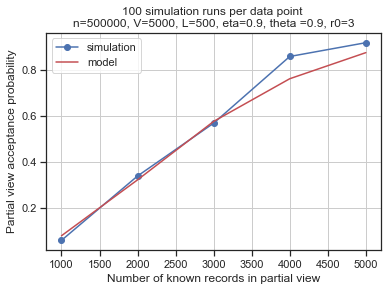

In [28]:
plot.title(str(mc_iter_count) +' simulation runs per data point \n' + 'n=' + str(n) + ', V=' + str(V) + ', L=' + str(L) + ', eta=' + str(eta) + ', theta =' + str(theta) + ', r0=' + str(r0))
plot.xlabel('Number of known records in partial view')
plot.ylabel('Partial view acceptance probability')
plot.plot(vs, successes_freq, '-bo', vs, [scipy.stats.hypergeom.sf(r0-1, n, L, v) for v in vs], 'r-')
#plot.plot(vs, [scipy.stats.hypergeom.sf(r0-1, n, L, v) for v in vs], 'r-')
plot.legend(['simulation', 'model'])
# plot.axvline(x=vopt, color='g')
# plot.text(vopt, -0.1, '$v_{opt}$')
# plot.axhline(y=scipy.stats.hypergeom.sf(r0-1, n, L, vopt), color='g')
# plot.text(700, scipy.stats.hypergeom.sf(r0-1, n, L, vopt) - 0.05, 'Acceptance prob at $v_{opt}$ = '+ str(scipy.stats.hypergeom.sf(r0-1, n, L, vopt)))
plot.grid()
plot.savefig('P(fake_PV_has_r0= ' + str(r0)+'_known_rows_dataset_500K)', dpi=300, bbox_inches='tight')
#plot.text(0, scipy.stats.hypergeom.sf(r0-1, n, L, vs[-1], 'P(pass with vopt)'))
#successes_freq, scipy.stats.hypergeom.sf(r0-1, n, L, v)

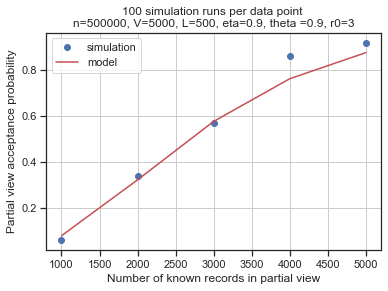

In [29]:
plot.title(str(mc_iter_count) +' simulation runs per data point \n' + 'n=' + str(n) + ', V=' + str(V) + ', L=' + str(L) + ', eta=' + str(eta) + ', theta =' + str(theta) + ', r0=' + str(r0))
plot.xlabel('Number of known records in partial view')
plot.ylabel('Partial view acceptance probability')
plot.plot(vs, successes_freq, 'bo', vs, [scipy.stats.hypergeom.sf(r0-1, n, L, v) for v in vs], 'r-')
#plot.plot(vs, [scipy.stats.hypergeom.sf(r0-1, n, L, v) for v in vs], 'r-')
plot.legend(['simulation', 'model'])
# plot.axvline(x=vopt, color='g')
# plot.text(vopt, -0.1, '$v_{opt}$')
# plot.axhline(y=scipy.stats.hypergeom.sf(r0-1, n, L, vopt), color='g')
# plot.text(700, scipy.stats.hypergeom.sf(r0-1, n, L, vopt) - 0.05, 'Acceptance prob at $v_{opt}$ = '+ str(scipy.stats.hypergeom.sf(r0-1, n, L, vopt)))
plot.grid()
plot.savefig('P(fake_PV_has_r0_known_rows_dataset_500K)', dpi=300, bbox_inches='tight')
#plot.text(0, scipy.stats.hypergeom.sf(r0-1, n, L, vs[-1], 'P(pass with vopt)'))
#successes_freq, scipy.stats.hypergeom.sf(r0-1, n, L, v)

In [23]:
vs, successes_freq, r0, vopt

([1000, 2000, 3000, 4000, 5000], [0.27, 0.64, 0.8, 0.91, 0.95], 2, 3890)

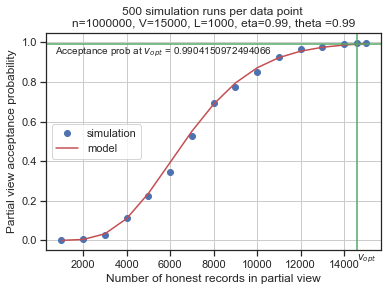

In [31]:
plot.title('500 simulation runs per data point \n' + 'n=' + str(n) + ', V=' + str(V) + ', L=' + str(L) + ', eta=' + str(eta) + ', theta =' + str(theta))
plot.xlabel('Number of honest records in partial view')
plot.ylabel('Partial view acceptance probability')
plot.plot(vs, successes_freq, 'bo', vs, [scipy.stats.hypergeom.sf(r0-1, n, L, v) for v in vs], 'r-')
#plot.plot(vs, [scipy.stats.hypergeom.sf(r0-1, n, L, v) for v in vs], 'r-')
plot.legend(['simulation', 'model'])
plot.axvline(x=vopt, color='g')
plot.text(vopt, -0.1, '$v_{opt}$')
plot.axhline(y=scipy.stats.hypergeom.sf(r0-1, n, L, vopt), color='g')
plot.text(700, scipy.stats.hypergeom.sf(r0-1, n, L, vopt) - 0.05, 'Acceptance prob at $v_{opt}$ = '+ str(scipy.stats.hypergeom.sf(r0-1, n, L, vopt)))
plot.grid()
#plot.text(0, scipy.stats.hypergeom.sf(r0-1, n, L, vs[-1], 'P(pass with vopt)'))
#successes_freq, scipy.stats.hypergeom.sf(r0-1, n, L, v)

In [21]:
vopt

14571

In [32]:
scipy.stats.hypergeom.sf(r0-1, n, L, vopt)

0.9904150972494066

In [35]:
V, L, r0

(15000, 1000, 7)

#### observation: the bigger the partial view size is, the bigger the vopt is

In [1]:
4/20

0.2